In [5]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from tqdm.autonotebook import tqdm
import os
import cftime
import json
from dask import array

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/srv/conda/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [1]:
def tcr_classic(ts_expt, ts_ctrl):
    m_expt = np.mean(ts_expt[0,60*12:80*12])
    m_ctrl = np.mean(ts_ctrl[0,60*12:80*12])
    std_expt = np.std(np.random.choice(ts_expt[0,60*12:80*12], 10000))
    std_ctrl = np.std(np.random.choice(ts_expt[0,60*12:80*12], 10000))
    return m_expt - m_ctrl, np.sqrt(np.sum(np.square([std_expt,std_ctrl])))

In [3]:
def load(*keys):
    test = lambda fname: all([k in fname for k in keys])
    ns = np.array([[f, np.load('data/'+f, allow_pickle = True)] for f in os.listdir('data') if test(f)])
    return ns

Plot 30-year moving average $\Delta T$  for 1pctCO2 runs
=======

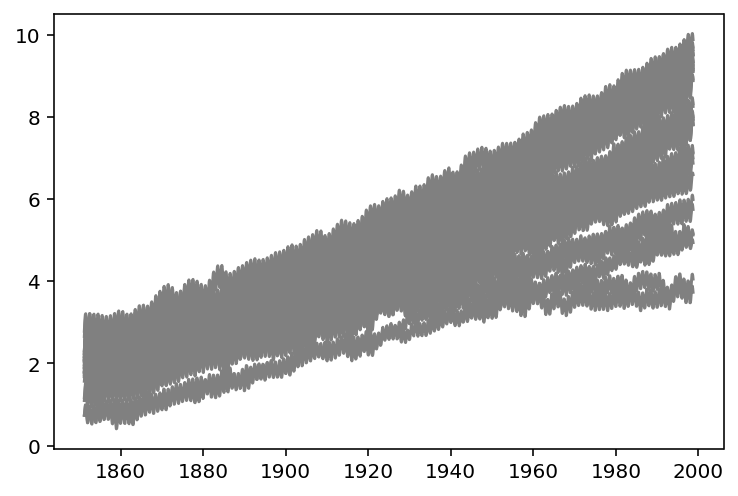

In [13]:
ns = load("1pctCO2",'_ts.npy')
below_ts = np.array([n for n in ns if np.mean(n[1][0]) < 200])
dates = [pd.to_datetime(n[1], errors='coerce') for n in ns[:,1]][0]
plt.figure("1pctCO2 runs")
for f, n in ns:
    if not isinstance(n[1,0], type(int)) and f not in below_ts[:,0]:
        w = 30
        plt.plot_date(dates[int(w/2)-1:int(len(n[0])-w/2)],
                      moving_average(n[0] - n[0,0], w),
                      xdate=True, fmt='-', color='grey')

Plot 30-year moving average $\Delta T$  for abrupt-4x runs
=======

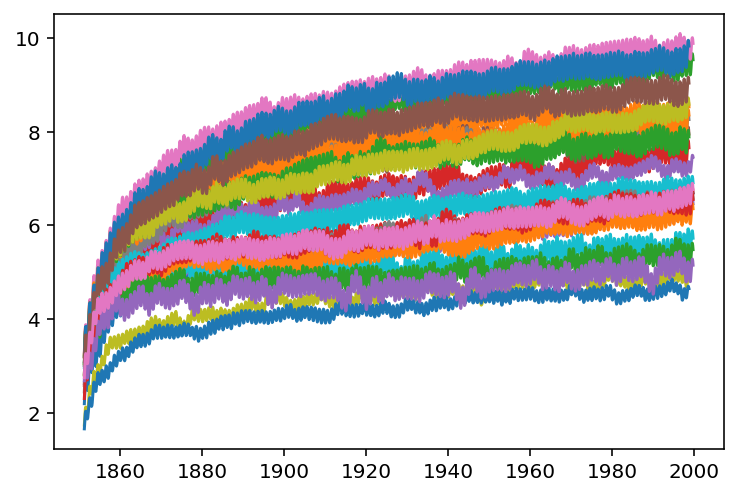

In [14]:
ns = np.array([[f, np.load('data/'+f, allow_pickle = True)] for f in os.listdir('data') if "abrupt" in f and '_ts.npy' in f])
below_ts = np.array([n[0] for n in ns if np.mean(n[1][0]) < 200])
short_ts = np.array([n[0] for n in ns if len(n[1][1]) < 1700])
dates = [d for d in [pd.to_datetime(n[1], errors='coerce') for n in ns[:,1]] if d[0] != 'NaT']
plt.figure("1pctCO2 runs")
for f, n in ns:
    if f not in below_ts and f not in short_ts:
        w = 30
        d = next(d for d in dates if len(d) == len(n[0]))
        plt.plot_date(d[int(w/2)-1:int(len(n[0])-w/2)],
                      moving_average(n[0] - n[0,0], w),
                      xdate=True, fmt='-')

In [7]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w    